In [1]:
!ls


cur_notebook_env.txt   jupyter_bootstrap.sh
cur_notebook_path.txt  jupyter_notebook_sbatch.sh


In [2]:
# Import dependencies
import numpy as np
import plotly.graph_objects as go
import sys
sys.path.append('src')
import utils
import height_funcs
from output import output
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

ModuleNotFoundError: No module named 'utils'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def visualize_height_by_radial_distance(ring_means, names, colors, file_path=None,
                                        envelope_heights=None, envelope_hline=None, sym=False,
                                        yrange=None, xrange=[-25, 25], size=(1000, 1000),
                                        annotation_pos=None, subtitle="", fill_between=None):
    """
    Visualize height over radial distance using Matplotlib.
    
    Parameters:
    - ring_means: list of 1D numpy arrays. Each array represents height values.
    - names: list of names for each trace.
    - colors: list of colors (one per trace).
    - file_path: optional; if provided, the figure is saved to this path.
    - envelope_heights: optional; 1D array for the nuclear envelope heights.
    - envelope_hline: optional; if provided, a horizontal line is drawn at this y value.
    - sym: bool; if True, the data is mirrored around 0.
    - yrange: tuple or list; y-axis limits.
    - xrange: tuple or list; x-axis limits.
    - size: tuple; figure size in pixels (width, height). (Converted to inches internally.)
    - annotation_pos: tuple (x, y) for annotating the nuclear envelope.
    - subtitle: string; additional subtitle text.
    - fill_between: optional; list of pairs [upper, lower] (each as arrays) to fill between.
    """
    # Convert pixel size to inches (assume 100 dpi)
    dpi = 100
    fig, ax = plt.subplots(figsize=(size[0] / dpi, size[1] / dpi), dpi=dpi)
    
    max_r = len(ring_means[0])
    if sym:
        # Create symmetric x values and mirrored y data
        x = np.arange(-max_r + 1, max_r)
        y = [np.concatenate((ring_mean[::-1][:-1], ring_mean)) for ring_mean in ring_means]
        if envelope_heights is not None:
            envelope_heights = np.concatenate((envelope_heights[::-1][:-1], envelope_heights))
        if fill_between is not None:
            temp = []
            for upper, lower in fill_between:
                new_upper = np.concatenate((upper[::-1][:-1], upper))
                new_lower = np.concatenate((lower[::-1][:-1], lower))
                temp.append((new_upper, new_lower))
            fill_between = temp
    else:
        x = np.arange(max_r)
        y = ring_means

    # Plot fill_between regions first (so they appear behind the main lines)
    if fill_between is not None:
        for i, (upper, lower) in enumerate(fill_between):
            ax.fill_between(x, lower, upper, color=colors[i], alpha=0.5)

    # Plot the main traces
    for i in range(len(names)):
        ax.plot(x, y[i], label=names[i], color=colors[i],
                linewidth=3.3, marker='o', markersize=0, linestyle='dashed')
    
    # Plot nuclear envelope (as a thick line with fill to y=0)
    if envelope_heights is not None:
        env_x = np.arange(-25, 26)
        ax.plot(env_x, envelope_heights, color="#2e2f30", linewidth=12, label="Nuclear Envelope")
        ax.fill_between(env_x, envelope_heights, 0, color='#2e2f30')
    
    # Add horizontal line if provided
    if envelope_hline is not None:
        ax.axhline(y=envelope_hline, linestyle="--", linewidth=2, color="black", label="Nuclear Envelope")
    
    # Add annotation for the nuclear envelope if provided
    if annotation_pos is not None:
        ax.annotate("Nuclear Envelope", xy=annotation_pos, xytext=annotation_pos,
                    fontsize=12, ha="center", va="center")
    
    # Set axis labels and title (subtitle is added as a newline)
    ax.set_xlabel("Distance from center (nm)", fontsize=16)
    ax.set_ylabel("Height (nm)", fontsize=16)
    title_text = "Mean height over distance" + ("\n" + subtitle if subtitle else "")
    ax.set_title(title_text, fontsize=16)
    
    # Set tick locators (ticks every 10 units)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    
    # Set axis limits if provided
    if yrange:
        ax.set_ylim(yrange)
    if xrange:
        ax.set_xlim(xrange)
    
    # Force equal scaling on both axes
    ax.set_aspect('equal')
    
    # Reverse the legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=12)
    
    # Customize the border (spines) and tick parameters
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_color('black')
    ax.tick_params(direction="out", length=6, width=1, colors='black')
    
    plt.tight_layout()
    
    # Save figure if a file path is provided
    if file_path is not None:
        plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True)
    
    plt.show()


In [3]:
p1 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/mini_0uM_100ns_40x40/1.pickle"
p2 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/mini_200uM_100ns_40x40/10.pickle"
paths = [p1, p2]
non_rasterized_maps = []
ring_means = []
args = output.load_pickle(paths[0])["args"]
args2 = args
args2["tip_radius_px"] = 0
for path in paths:
    non_rasterized_maps.append(output.load_pickle(path)["non_rasterized_maps"])
for i in range(len(paths)):
    ring_means.append(utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_maps[i]), axis=2),
                                                    non_rasterized_maps[i][0].shape[0] / 2,
                                                    non_rasterized_maps[i][0].shape[1] / 2) - 40)
envelope_heights = np.array([height_funcs.get_slab_top_z(x, 20, (20, 20, 40), args2) - 40 for x in range(20, 20 + 26)])


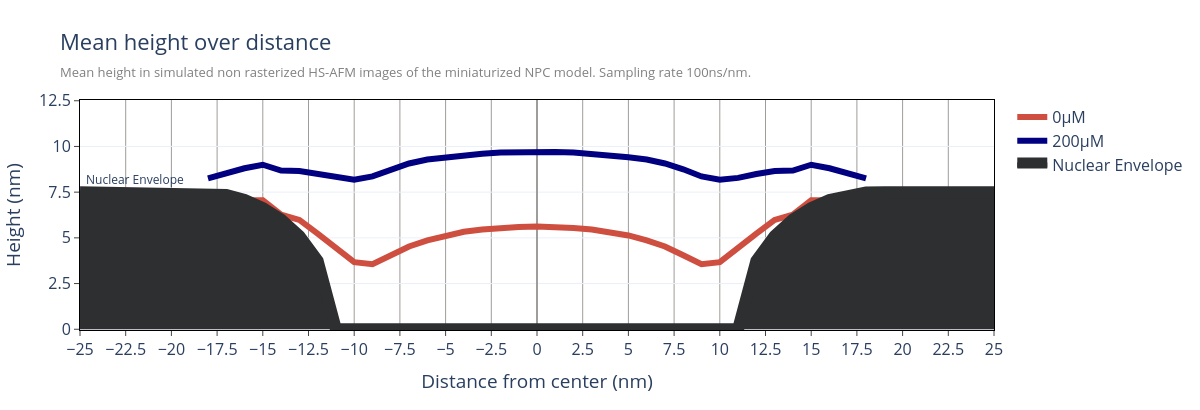

In [ ]:
visualize_height_by_radial_distance(ring_means, 
                                    ["0μM", "200μM"],
                                    ["#ce4e40", "#000080"],
                                    "",
                                    envelope_heights=envelope_heights,
                                    sym=True,
                                    yrange=[0, 12.5],
                                    size=(1200, 410),
                                    annotation_pos=(-22, 8.2),
                                    subtitle="Mean height in simulated non rasterized HS-AFM images of the miniaturized NPC model. Sampling rate 100ns/nm.")

In [ ]:
# todo: same for full pore. 
p1 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_0uM_1ns/3.pickle"
p2 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_50uM_1ns/3.pickle"
paths = [p1, p2]
non_rasterized_maps = []
ring_means = []
args = output.load_pickle(paths[0])["args"]
args2 = args
args2["tip_radius_px"] = 0
for path in paths:
    non_rasterized_maps.append(output.load_pickle(path)["non_rasterized_maps"])
for i in range(len(paths)):
    ring_means.append(utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_maps[i]), axis=2),
                                                                   non_rasterized_maps[i][0].shape[0] / 2,
                                                                   non_rasterized_maps[i][0].shape[1] / 2) - 40)
envelope_heights = np.array([height_funcs.get_slab_top_z(x, 40, (40, 40, 40), args2) - 40 for x in range(40, 80)])

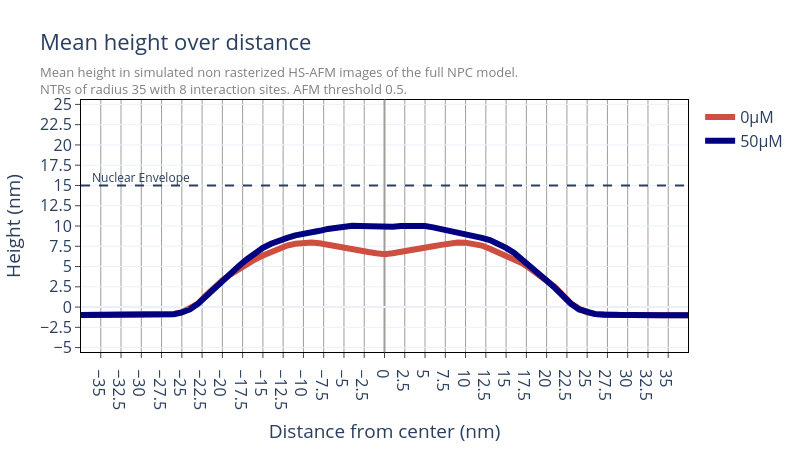

In [ ]:
visualize_height_by_radial_distance(ring_means,
                                    ["0μM", "50μM"],
                                    ["#ce4e40", "#000080"],
                                    "",
                                    sym=True,
                                    yrange=[0, 20],
                                    xrange=[-35, 35],
                                    envelope_hline=15,
                                    size=(800, 450),
                                    annotation_pos=(-30, 16),
                                    subtitle="Mean height in simulated non rasterized HS-AFM images of the full NPC model. <br>NTRs of radius 35 with 8 interaction sites. AFM threshold 0.5. Sampling rate 1ns."
                                    )

In [ ]:
p1 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_0uM_1ns/5.pickle"
p2 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_50uM_1ns/5.pickle"
paths = [p1, p2]
non_rasterized_maps = []
args = output.load_pickle(paths[0])["args"]
args2 = args
args2["tip_radius_px"] = 0
for path in paths:
    non_rasterized_maps.append(output.load_pickle(path)["non_rasterized_maps"])


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbbe3f958a0>>
Traceback (most recent call last):
  File "/cs/labs/ravehb/roi.eliasian/miniconda3/envs/general_notebooks/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbbe3f958a0>>
Traceback (most recent call last):
  File "/cs/labs/ravehb/roi.eliasian/miniconda3/envs/general_notebooks/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbbe3f958a0>>
Traceback (most recent call last):
  File "/cs/labs/ravehb/r

In [ ]:
ring_means_t = []
for t in range(7):
    ring_means_t.append([[],[]])
    for i in range(len(paths)):
        ring_means_t[t][i] = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_maps[i][t*10000:(t+1)*10000]), axis=2),
                                                                    non_rasterized_maps[i][0].shape[0] / 2,
                                                                    non_rasterized_maps[i][0].shape[1] / 2) - 40
        # envelope_heights = np.array([height_funcs.get_slab_top_z(x, 40, (40, 40, 40), args2) - 40 for x in range(40, 80)])

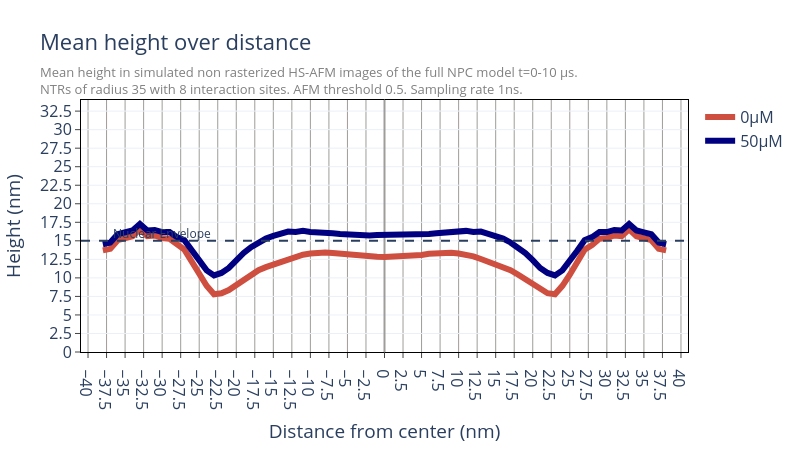

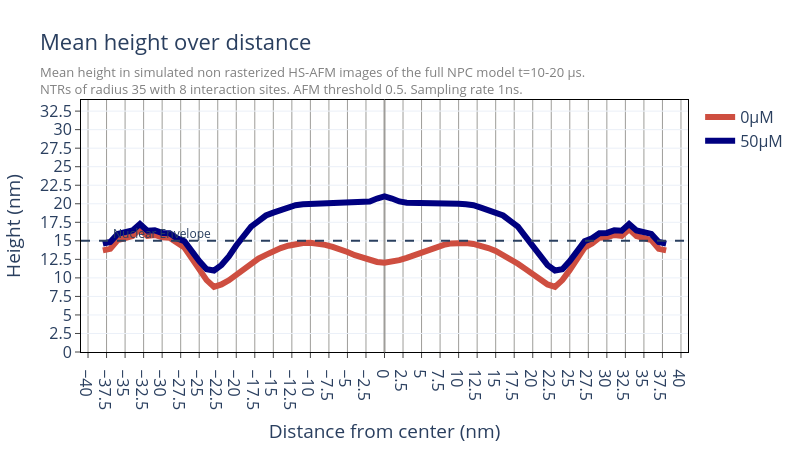

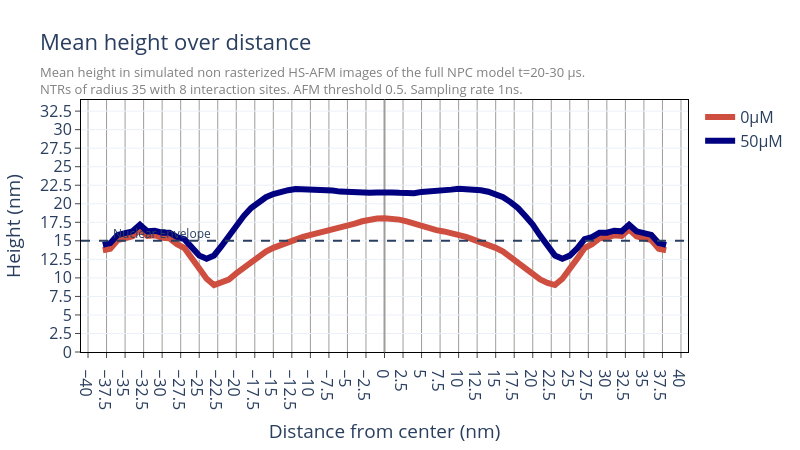

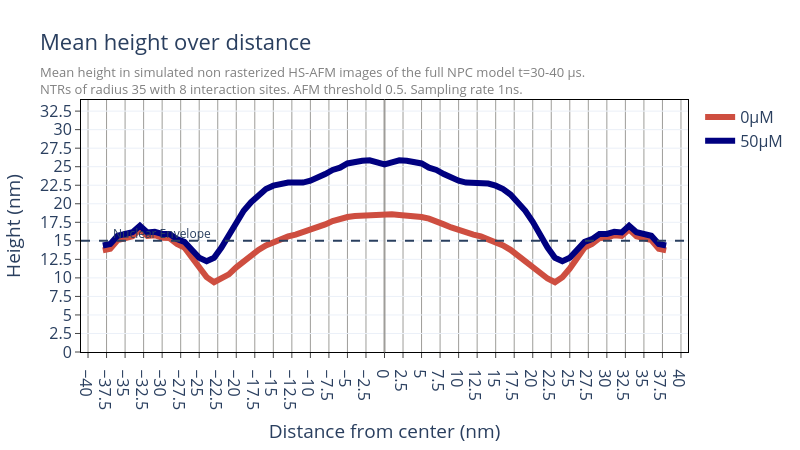

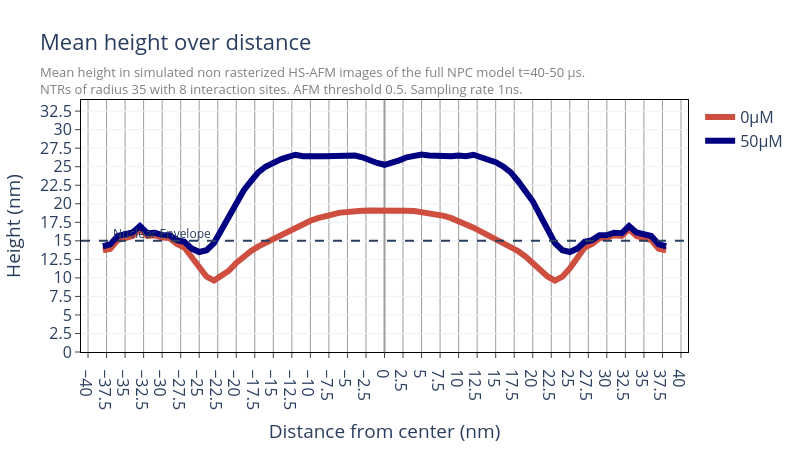

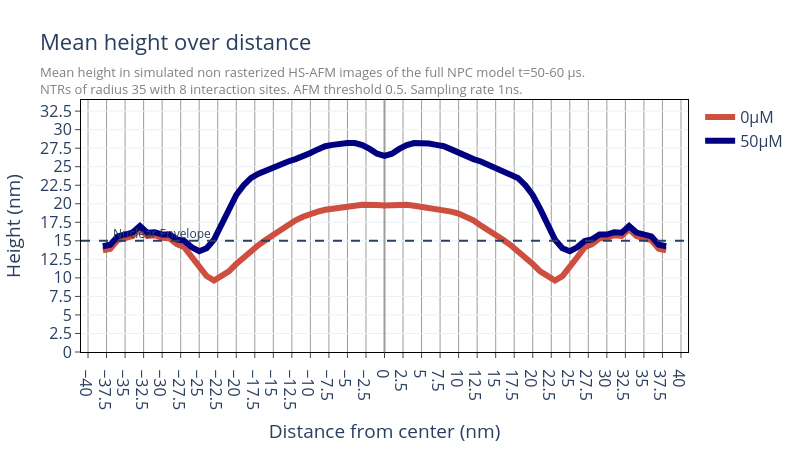

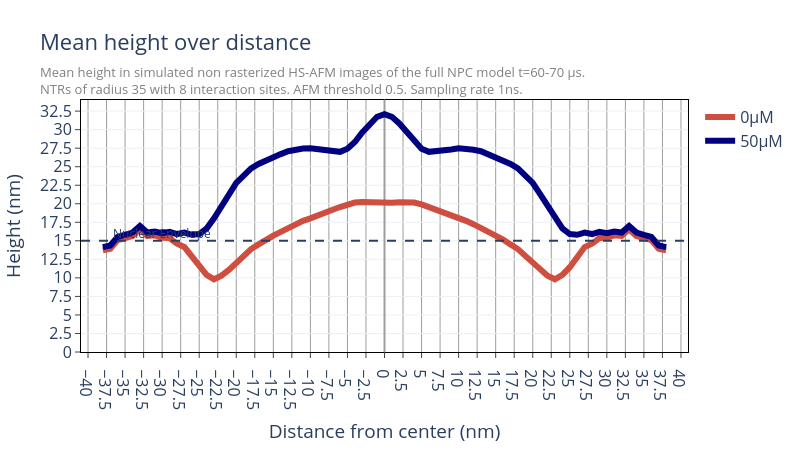

In [ ]:
for t in range(7):
    visualize_height_by_radial_distance(ring_means_t[t],
                                    ["0μM", "50μM"],
                                    ["#ce4e40", "#000080"],
                                    "",
                                    sym=True,
                                    yrange=[0, 34],
                                    xrange=[-35, 35],
                                    envelope_hline=15,
                                    size=(800, 450),
                                    annotation_pos=(-30, 16),
                                    subtitle=f"Mean height in simulated non rasterized HS-AFM images of the full NPC model t={t*10}-{(t+1)*10} µs. <br>NTRs of radius 35 with 8 interaction sites. AFM threshold 0.5. Sampling rate 1ns."
                                    )

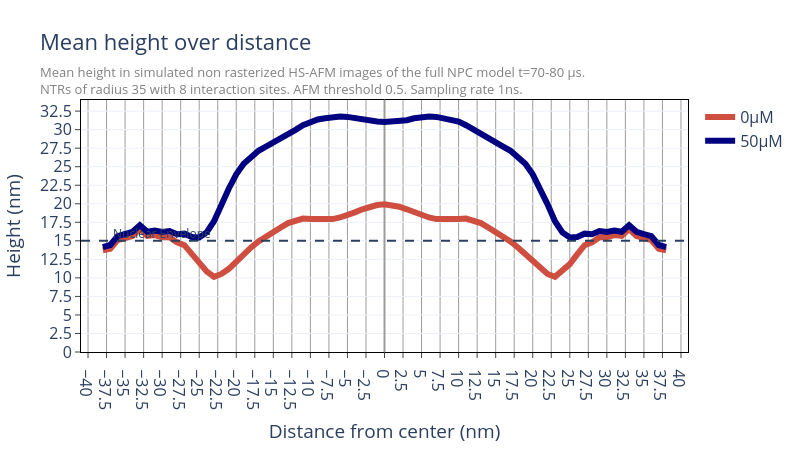

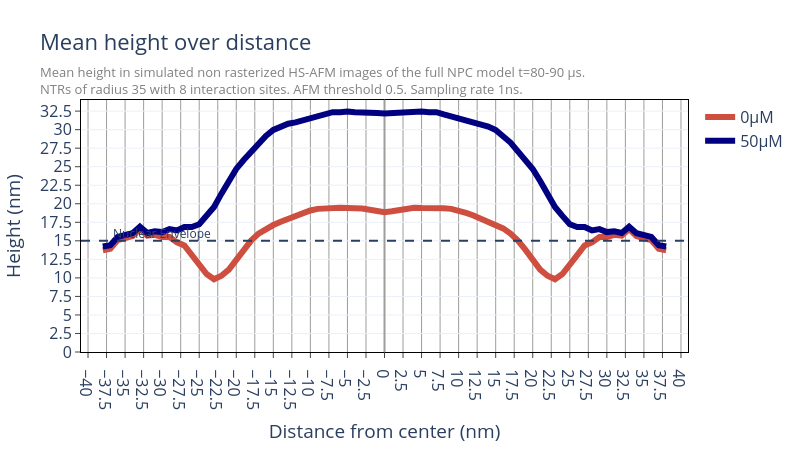

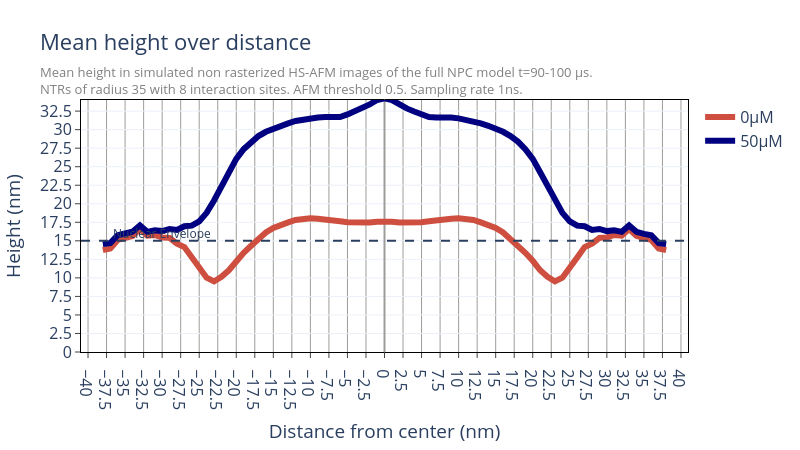

IndexError: list index out of range

In [4]:
p1 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_0uM_1ns/6.pickle"
p2 = "/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/full_50uM_1ns/6.pickle"
paths = [p1, p2]
non_rasterized_maps = []
args = output.load_pickle(paths[0])["args"]
args2 = args
args2["tip_radius_px"] = 0
for path in paths:
    non_rasterized_maps.append(output.load_pickle(path)["non_rasterized_maps"])

ring_means_t = []
for t in range(3):
    ring_means_t.append([[],[]])
    for i in range(len(paths)):
        ring_means_t[t][i] = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_maps[i][t*10000:(t+1)*10000]), axis=2),
                                                                    non_rasterized_maps[i][0].shape[0] / 2,
                                                                    non_rasterized_maps[i][0].shape[1] / 2) - 40
        # envelope_heights = np.array([height_funcs.get_slab_top_z(x, 40, (40, 40, 40), args2) - 40 for x in range(40, 80)])
        
for t in range(7):
    visualize_height_by_radial_distance(ring_means_t[t],
                                    ["0μM", "50μM"],
                                    ["#ce4e40", "#000080"],
                                    "",
                                    sym=True,
                                    yrange=[0, 34],
                                    xrange=[-35, 35],
                                    envelope_hline=15,
                                    size=(800, 450),
                                    annotation_pos=(-30, 16),
                                    subtitle=f"Mean height in simulated non rasterized HS-AFM images of the full NPC model t={(t+7)*10}-{(t+8)*10} µs. <br>NTRs of radius 35 with 8 interaction sites. AFM threshold 0.5. Sampling rate 1ns."
                                    )

In [6]:
for w in ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"]:
    print(w)
    non_rasterized_map = output.load_pickle(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/free_parameter_scan/0uM_100us_w{w}.pickle")["non_rasterized_maps"]
    ring_mean = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_map[0:9900]), axis=2),
                                                            non_rasterized_map[0].shape[0] / 2,
                                                            non_rasterized_map[0].shape[1] / 2) - 40
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_100us_w{w}.pickle", "wb") as f:
        pickle.dump(ring_mean, f)
        
for w in ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"]:
    print(w)
    non_rasterized_map = output.load_pickle(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/free_parameter_scan/50uM_200us_w{w}.pickle")["non_rasterized_maps"]
    ring_mean = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_map[0:9900]), axis=2),
                                                            non_rasterized_map[0].shape[0] / 2,
                                                            non_rasterized_map[0].shape[1] / 2) - 40
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_200us_w{w}.pickle", "wb") as f:
        pickle.dump(ring_mean, f)

0.65
0.7
0.8
1.0
1.2
1.5
2.0
0.65
0.7
0.8
1.0
1.2
1.5
2.0


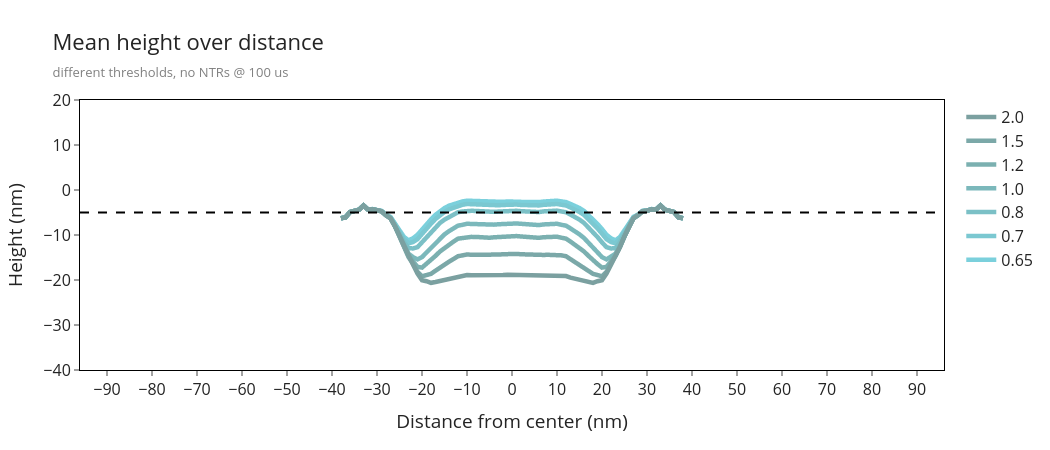

In [7]:
ring_means = []
for w in ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"]:
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_100us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f))

scaffold_height = 20
visualize_height_by_radial_distance([ring_mean - scaffold_height for ring_mean in ring_means],
                                ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"],
                                ["#7bd0dc", "#7bc8d1", "#7bc0c6", "#7bb8bb", "#7bb0b0", "#7ba8a8", "#7ba0a0"],
                                "",
                                sym=True,
                                yrange=[-40, 20],
                                xrange=[-70, 70],
                                envelope_hline=15 - scaffold_height,
                                size=(1050, 450),
                                subtitle="different thresholds, no NTRs @ 100 us"
                                )

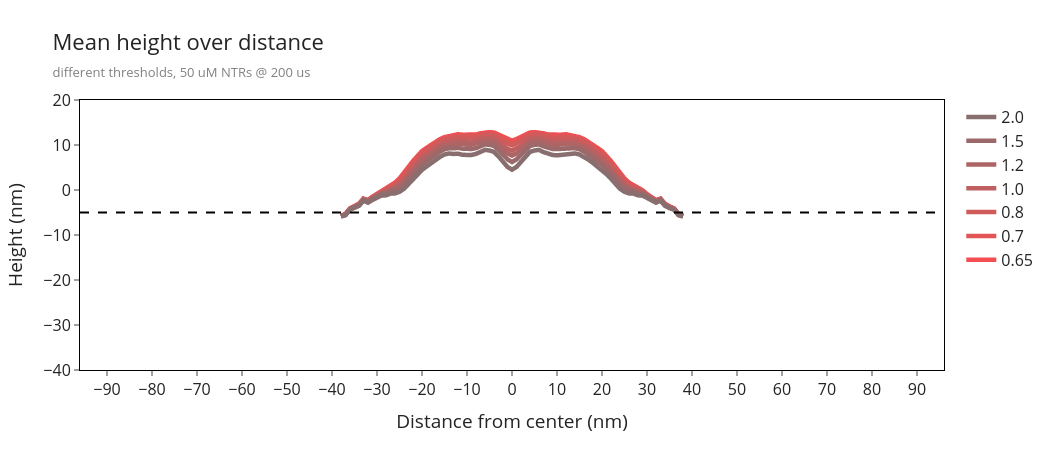

In [ ]:
ring_means = []
for w in ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"]:
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_200us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f))

scaffold_height = 20
visualize_height_by_radial_distance([ring_mean - scaffold_height for ring_mean in ring_means],
                                ["0.65", "0.7", "0.8", "1.0", "1.2", "1.5", "2.0"],
                                ["#f54e52", "#e35456", "#d15a5b", "#bf5f60", "#ad6465", "#9b696a", "#896e6f"],
                                "",
                                sym=True,
                                yrange=[-40, 20],
                                xrange=[-70, 70],
                                envelope_hline=15 - scaffold_height,
                                size=(1050, 450),
                                subtitle="different thresholds, 50 uM NTRs @ 200 us"
                                )

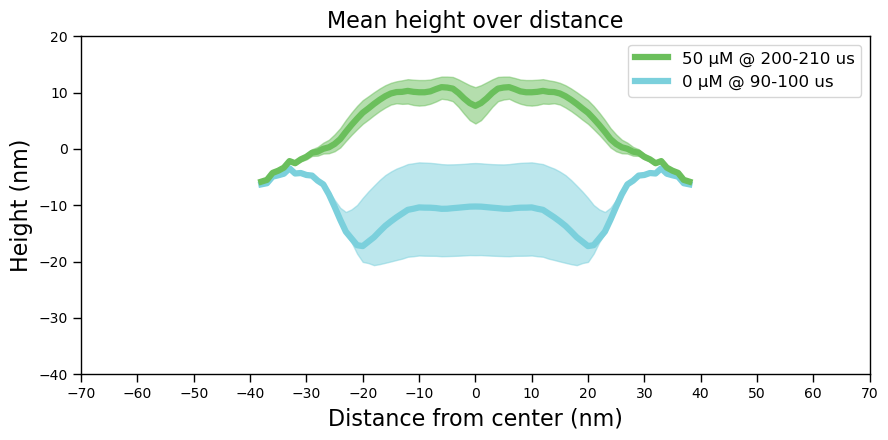

In [8]:
scaffold_height = 20 # 0 in rod's fig assumed to be the mean height of the scaffold
w = "1.2"

ring_means = []
fill_between = [[],[]]
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_100us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_200us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f) - scaffold_height)
        
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_100us_w0.65.pickle", "rb") as f:
        fill_between[0].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_100us_w2.0.pickle", "rb") as f:
        fill_between[0].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_200us_w0.65.pickle", "rb") as f:
        fill_between[1].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_200us_w2.0.pickle", "rb") as f:
        fill_between[1].append(pickle.load(f) - scaffold_height)

visualize_height_by_radial_distance(ring_means,
                                ["0 μM @ 90-100 us", "50 μM @ 200-210 us"],
                                ["#7bd0dc", "#6bbf5c"],
                                sym=True,
                                yrange=[-40, 20],
                                xrange=[-70, 70],
                                envelope_hline=None,
                                size=(1050, 450),
                                subtitle="",
                                fill_between=fill_between,
                                file_path="height.svg"
                                )

In [3]:
# height at 30 us - 40 us

for w in ["0.65", "1.2", "2.0"]:
    print(w)
    non_rasterized_map = output.load_pickle(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/free_parameter_scan/0uM_40us_w{w}.pickle")["non_rasterized_maps"]
    ring_mean = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_map[0:9900]), axis=2),
                                                            non_rasterized_map[0].shape[0] / 2,
                                                            non_rasterized_map[0].shape[1] / 2) - 40
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_40us_w{w}.pickle", "wb") as f:
        pickle.dump(ring_mean, f)
        
for w in ["0.65", "1.2", "2.0"]:
    print(w)
    non_rasterized_map = output.load_pickle(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Dataset/dataset/afm/new/free_parameter_scan/50uM_40us_w{w}.pickle")["non_rasterized_maps"]
    ring_mean = utils.get_ring_means_array(np.mean(np.dstack(non_rasterized_map[0:9900]), axis=2),
                                                            non_rasterized_map[0].shape[0] / 2,
                                                            non_rasterized_map[0].shape[1] / 2) - 40
    with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_40us_w{w}.pickle", "wb") as f:
        pickle.dump(ring_mean, f)

0.65
1.2
2.0
0.65
1.2
2.0


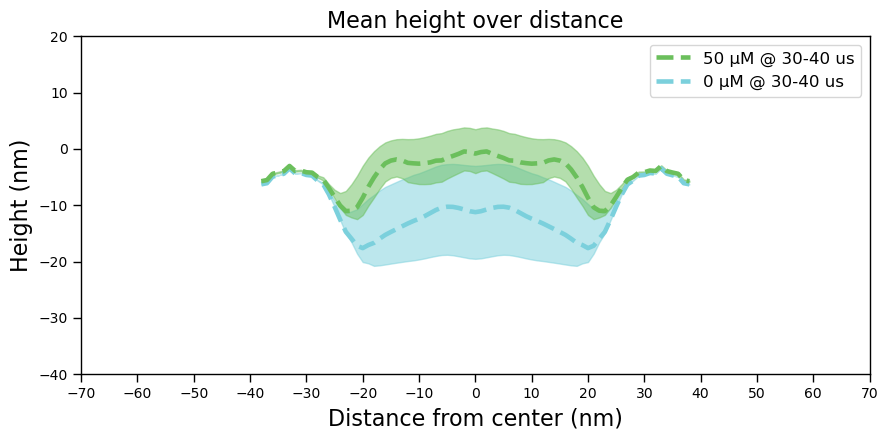

In [5]:
scaffold_height = 20 # 0 in rod's fig assumed to be the mean height of the scaffold
w = "1.2"

ring_means = []
fill_between = [[],[]]
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_40us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_40us_w{w}.pickle", "rb") as f:
        ring_means.append(pickle.load(f) - scaffold_height)
        
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_40us_w0.65.pickle", "rb") as f:
        fill_between[0].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_0uM_40us_w2.0.pickle", "rb") as f:
        fill_between[0].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_40us_w0.65.pickle", "rb") as f:
        fill_between[1].append(pickle.load(f) - scaffold_height)
with open(f"/cs/usr/roi.eliasian/LabFolder/NpcTransportExperiment/HS-AFM-Simulation/experiments/cache/ring_means_50uM_40us_w2.0.pickle", "rb") as f:
        fill_between[1].append(pickle.load(f) - scaffold_height)

visualize_height_by_radial_distance(ring_means,
                                ["0 μM @ 30-40 us", "50 μM @ 30-40 us"],
                                ["#7bd0dc", "#6bbf5c"],
                                sym=True,
                                yrange=[-40, 20],
                                xrange=[-70, 70],
                                envelope_hline=None,
                                size=(1050, 450),
                                subtitle="",
                                fill_between=fill_between,
                                file_path="height.svg"
                                )